In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#from pandas.io import gbq

In [2]:
%load_ext google.cloud.bigquery

In [3]:
project_id='izettle-dp-pipeline-prod'

# Dataset: google_analytics_session

In [3]:
users = '''
                            SELECT 
                                Count(DISTINCT full_visitor_id) AS nr_visitors, 
                                COUNT(DISTINCT client_id) AS nr_clients,
                                COUNT(DISTINCT organization_uuid) AS nr_customers
                            FROM legacy_views.google_analytics_session
                         '''

In [4]:
users_sql = gbq.read_gbq(query=users, dialect ='standard', project_id = project_id)
print(users_sql)

//anaconda3/lib/python3.7/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


   nr_visitors  nr_clients  nr_customers
0      4927226     4855266        399013


In [5]:
print(users_sql)

   nr_visitors  nr_clients  nr_customers
0      4927226     4855266        399013


# Data Quality Check

- Type
- NA values
- Duplicates
- Outliers

### 1. Duplicates

In [3]:
check = '''
        SELECT 
            *
        FROM 
            `izettle-dp-pipeline-prod.legacy_views.google_analytics_session`
        ORDER BY 
            full_visitor_id,
            session_id
        LIMIT 2000
'''

check_sql = gbq.read_gbq(query = check, dialect = 'standard', project_id = project_id)

//anaconda3/lib/python3.7/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [5]:
check_sql.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 34 columns):
full_visitor_id                        2000 non-null object
client_id                              1987 non-null object
organization_uuid                      1232 non-null object
country_id                             1993 non-null object
session_id                             2000 non-null object
session_start_time                     2000 non-null datetime64[ns, UTC]
session_end_time                       2000 non-null datetime64[ns, UTC]
session_first_vertical_page_visited    234 non-null object
session_last_vertical_page_visited     234 non-null object
session_nr_vertical_pages_visited      2000 non-null int64
traffic_source_level_1                 2000 non-null object
traffic_source_level_2                 2000 non-null object
traffic_source_level_3                 2000 non-null object
traffic_source_referral_path           2000 non-null object
traffic_source_campaign       

In [7]:
check_sql.duplicated().sum().sum()

688

Duplicates found in the processed GA data. So now, check duplicates in the raw data.

**Check duplicates in the raw GA data**

In [36]:
from pandas.io import gbq

In [28]:
project = 'izettle-dp-events-prod'

In [38]:
select = '''
        SELECT 
            *
        FROM events.big_query_google_analytics_session
        LIMIT 20000
        '''

In [39]:
select_sql = gbq.read_gbq(query = select, dialect = 'standard', project_id = project)

In [40]:
select_sql.duplicated().sum()

0

No duplicates found in a subset of GA raw data. So duplicates found in the processed GA data are due to merge or a subselection of fields in the raw data

### 2. Data type and values

In [4]:
%%bigquery df
SELECT 
    client_id, 
    organization_uuid,
    country_id,
    session_id,
    session_start_time,
    session_end_time,
    traffic_source_level_1,
    traffic_source_level_2,
    traffic_source_level_3,
    device_is_mobile,
    device_browser,
    is_portal_login_session
FROM legacy_views.google_analytics_session
LIMIT 1000

In [5]:
df.head(10)

,client_id,organization_uuid,country_id,session_id,session_start_time,session_end_time,traffic_source_level_1,traffic_source_level_2,traffic_source_level_3,device_is_mobile,device_browser,is_portal_login_session
0,340481026.1515878162,None,NL,b'\xbfq\xedJ\xe4DRFI\xde\xc6\xffW\xce\xdc\x03\...,2018-01-13 21:16:03+00:00,2018-01-13 21:16:18+00:00,online,o_paid,o_paid_sem,True,Safari,False
1,340481026.1515878162,None,NL,b'\xbfq\xedJ\xe4DRFI\xde\xc6\xffW\xce\xdc\x03\...,2018-01-13 21:16:03+00:00,2018-01-13 21:16:18+00:00,online,o_paid,o_paid_sem,True,Safari,False
2,340481026.1515878162,None,NL,b'\xbfq\xedJ\xe4DRFI\xde\xc6\xffW\xce\xdc\x03\...,2018-01-13 21:16:03+00:00,2018-01-13 21:16:18+00:00,online,o_paid,o_paid_sem,True,Safari,False
3,340481026.1515878162,None,NL,b'\xbfq\xedJ\xe4DRFI\xde\xc6\xffW\xce\xdc\x03\...,2018-01-13 21:16:03+00:00,2018-01-13 21:16:18+00:00,online,o_paid,o_paid_sem,True,Safari,False
4,None,10b60a50-f778-11e5-a659-0c2c30ab3382,BR,b'\x9c|v\xb4JS\x92\x92\x81\x9c\x89\xa6)\xd7\x9...,2018-01-13 17:50:21+00:00,2018-01-13 17:50:21+00:00,online,o_paid,o_paid_sem,True,Chrome,True
5,None,10b60a50-f778-11e5-a659-0c2c30ab3382,BR,b'\x9c|v\xb4JS\x92\x92\x81\x9c\x89\xa6)\xd7\x9...,2018-01-13 17:50:21+00:00,2018-01-13 17:50:21+00:00,online,o_paid,o_paid_sem,True,Chrome,True
6,885288598.1510656930,3fe871a0-c73d-11e7-8852-5d15a595a48e,BR,b'0\x8fG\xb5\x01\xab\x05\xcd\x88A\x05p\x00\x98...,2018-01-13 14:19:17+00:00,2018-01-13 14:20:23+00:00,online,o_organic,o_organic_null,False,Safari,True
7,885288598.1510656930,3fe871a0-c73d-11e7-8852-5d15a595a48e,BR,b'0\x8fG\xb5\x01\xab\x05\xcd\x88A\x05p\x00\x98...,2018-01-13 14:19:17+00:00,2018-01-13 14:20:23+00:00,online,o_organic,o_organic_null,False,Safari,True
8,885288598.1510656930,3fe871a0-c73d-11e7-8852-5d15a595a48e,BR,b'0\x8fG\xb5\x01\xab\x05\xcd\x88A\x05p\x00\x98...,2018-01-13 14:19:17+00:00,2018-01-13 14:20:23+00:00,online,o_organic,o_organic_null,False,Safari,True
9,885288598.1510656930,3fe871a0-c73d-11e7-8852-5d15a595a48e,BR,b'0\x8fG\xb5\x01\xab\x05\xcd\x88A\x05p\x00\x98...,2018-01-13 14:19:17+00:00,2018-01-13 14:20:23+00:00,online,o_organic,o_organic_null,False,Safari,True


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
client_id                  777 non-null object
organization_uuid          446 non-null object
country_id                 995 non-null object
session_id                 1000 non-null object
session_start_time         1000 non-null datetime64[ns, UTC]
session_end_time           1000 non-null datetime64[ns, UTC]
traffic_source_level_1     1000 non-null object
traffic_source_level_2     1000 non-null object
traffic_source_level_3     1000 non-null object
device_is_mobile           1000 non-null bool
device_browser             1000 non-null object
is_portal_login_session    1000 non-null bool
dtypes: bool(2), datetime64[ns, UTC](2), object(8)
memory usage: 80.2+ KB


In [7]:
%%bigquery df_value
SELECT
    COUNT(DISTINCT client_id) AS nr_id,
    COUNT(DISTINCT organization_uuid) AS nr_or,
    COUNT(DISTINCT country_id) AS nr_country,
    COUNT(DISTINCT session_id) AS nr_session,
    MIN(session_start_time) AS start_time,
    MAX(session_end_time) AS end_time,
    COUNT(DISTINCT traffic_source_level_1) AS nr_traffic1,
    COUNT(DISTINCT traffic_source_level_2) AS nr_traffic2,
    COUNT(DISTINCT traffic_source_level_3) AS nr_traffic3,
    COUNT(DISTINCT device_browser) AS nr_browser
FROM legacy_views.google_analytics_session

In [8]:
df_value

,nr_id,nr_or,nr_country,nr_session,start_time,end_time,nr_traffic1,nr_traffic2,nr_traffic3,nr_browser
0,17123216,968157,12,44357521,2017-09-01 00:00:05+00:00,2019-09-30 21:59:59+00:00,3,8,17,9378


Note: GA cannt track returning users and cannt track across devices & browsers

### 3. NA values

In [9]:
df.isna().sum()

client_id                  223
organization_uuid          554
country_id                   5
session_id                   0
session_start_time           0
session_end_time             0
traffic_source_level_1       0
traffic_source_level_2       0
traffic_source_level_3       0
device_is_mobile             0
device_browser               0
is_portal_login_session      0
dtype: int64

554 NA orgonization_uuid/ 1000 records

In [10]:
%%bigquery df_na
SELECT 
    COUNT(*)
FROM legacy_views.google_analytics_session
WHERE organization_uuid IS NULL

In [11]:
df_na

,f0_
0,99229804


33% of the total obs that have  NA organization_uuid 

In [47]:
%%bigquery df_na_2
SELECT 
    COUNT(DISTINCT client_id)
FROM legacy_views.google_analytics_session
WHERE organization_uuid IS NULL

In [48]:
df_na_2

,f0_
0,14843068


33% contains 15millions different client_id (total 17 millions: 88%) -> Expectedly: low conversion from client_id to organization_uuid

# Data Exploration

### 1. Overview

In [14]:
%%bigquery session
SELECT 
    country_id,
    COUNT(DISTINCT session_id) AS nr_session
FROM legacy_views.google_analytics_session
GROUP BY country_id
ORDER BY 1


**Number of sessions by markets**

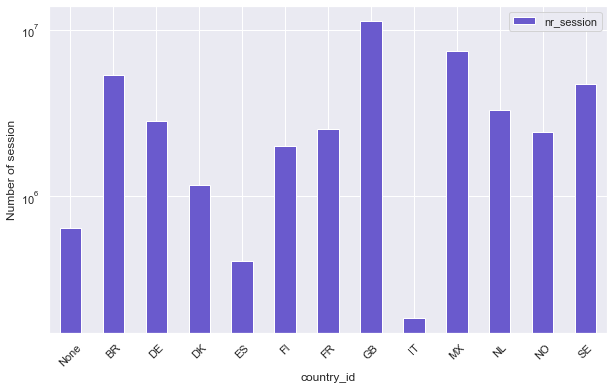

In [15]:
sns.set(rc = {'figure.figsize':(10,6)})
session.plot(kind = 'bar', x= 'country_id', y ='nr_session', color = 'slateblue', logy = True, rot = 45)
plt.ylabel('Number of session')
plt.show()

**Session duration**

In [16]:
%%bigquery session_duration
WITH duration_session AS(
                SELECT
                    DISTINCT country_id,
                    session_id,
                    TIMESTAMP_DIFF(session_end_time, session_start_time, second) AS sec
                    
                FROM `izettle-dp-pipeline-prod.legacy_views.google_analytics_session`
                )
SELECT
    DISTINCT country_id,
    PERCENTILE_CONT(sec, 0) OVER(PARTITION BY country_id) AS min_sec,
    PERCENTILE_CONT(sec, 1) OVER(PARTITION BY country_id) AS max_sec,
    PERCENTILE_CONT(sec, 0.5) OVER(PARTITION BY country_id) AS median_sec
FROM duration_session

In [17]:
session_duration

,country_id,min_sec,max_sec,median_sec
0,None,0.0,15120.0,0.0
1,DE,0.0,73100.0,12.0
2,DK,0.0,30860.0,8.0
3,FR,0.0,26137.0,1.0
4,ES,0.0,22341.0,9.0
5,GB,0.0,38906.0,8.0
6,SE,0.0,44052.0,12.0
7,MX,0.0,31332.0,2.0
8,BR,0.0,24412.0,5.0
9,IT,0.0,13869.0,15.0


*Skewed to the right*

Avg = 3.053 (mins)

In [18]:
%%bigquery session_distribution
WITH duration_session AS(
                SELECT
                    DISTINCT session_id,
                    CASE WHEN TIMESTAMP_DIFF(session_end_time, session_start_time, minute) <= 1 THEN ".0-1"
                          WHEN TIMESTAMP_DIFF(session_end_time, session_start_time, minute) <= 2 THEN ".1-2"
                          WHEN TIMESTAMP_DIFF(session_end_time, session_start_time, minute) <= 3 THEN ".2-3"
                          WHEN TIMESTAMP_DIFF(session_end_time, session_start_time, minute) <= 4 THEN ".3-4"
                          WHEN TIMESTAMP_DIFF(session_end_time, session_start_time, minute) <= 5 THEN ".4-5"
                          WHEN TIMESTAMP_DIFF(session_end_time, session_start_time, minute) <= 10 THEN ".5-10"
                          WHEN TIMESTAMP_DIFF(session_end_time, session_start_time, minute) <= 15 THEN "10-15"
                          WHEN TIMESTAMP_DIFF(session_end_time, session_start_time, minute) <= 20 THEN "15-20"
                          WHEN TIMESTAMP_DIFF(session_end_time, session_start_time, minute) <= 30 THEN "20-30"
                          WHEN TIMESTAMP_DIFF(session_end_time, session_start_time, minute) <= 60 THEN "30-60"
                          WHEN TIMESTAMP_DIFF(session_end_time, session_start_time, minute) <= 120 THEN "60-120"
                          WHEN TIMESTAMP_DIFF(session_end_time, session_start_time, minute) <= 240 THEN "120-240"
                          ELSE "> 240" END AS range_mins
                FROM `izettle-dp-pipeline-prod.legacy_views.google_analytics_session`
)
SELECT
    DISTINCT range_mins,
    COUNT(*) OVER(PARTITION BY range_mins) AS nr
FROM duration_session
ORDER BY 1

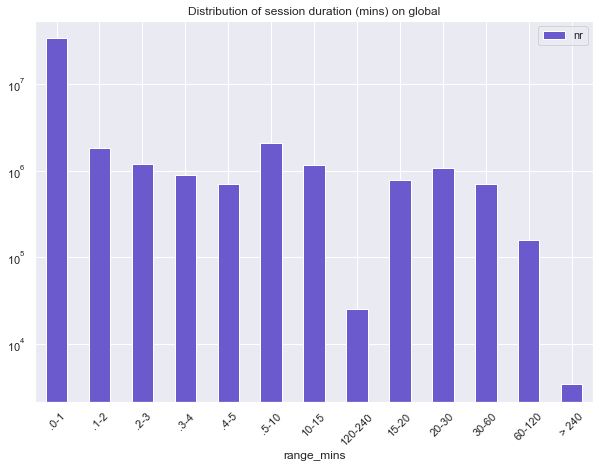

In [19]:
sns.set(rc = {'figure.figsize':(10,7)})
session_distribution.plot(kind = 'bar', x = 'range_mins', y = 'nr', color = 'slateblue', logy = True, rot = 45)
plt.title('Distribution of session duration (mins) on global')
plt.show()

remove session duration with 0 sec or less than certain threshold (<5s)? NO due to settings (no interaction -> session duration is automatically set at 0)

*Check GB distribution*

In [20]:
%%bigquery session_duration_GB
WITH duration_session_GB AS(
                SELECT
                    DISTINCT session_id,
                    TIMESTAMP_DIFF(session_end_time, session_start_time, second) AS sec
                FROM `izettle-dp-pipeline-prod.legacy_views.google_analytics_session`
                WHERE country_id = 'GB'
                )
SELECT
    PERCENTILE_CONT(sec, 0) OVER() AS min_sec,
    PERCENTILE_CONT(sec, 1) OVER() AS max_sec,
    (SELECT 
         AVG(sec)
     FROM duration_session_GB) AS avg_sec,
    PERCENTILE_CONT(sec, 0.5) OVER() AS median_sec
FROM duration_session_GB
LIMIT 1

In [21]:
session_duration_GB

,min_sec,max_sec,avg_sec,median_sec
0,0.0,38906.0,204.479835,8.0


avg ~ 3.17 mins

In [22]:
%%bigquery session_distribution_GB
WITH duration_session AS(
                SELECT
                    DISTINCT session_id,
                    CASE WHEN TIMESTAMP_DIFF(session_end_time, session_start_time, minute) <= 1 THEN ".0-1"
                          WHEN TIMESTAMP_DIFF(session_end_time, session_start_time, minute) <= 2 THEN ".1-2"
                          WHEN TIMESTAMP_DIFF(session_end_time, session_start_time, minute) <= 3 THEN ".2-3"
                          WHEN TIMESTAMP_DIFF(session_end_time, session_start_time, minute) <= 4 THEN ".3-4"
                          WHEN TIMESTAMP_DIFF(session_end_time, session_start_time, minute) <= 5 THEN ".4-5"
                          WHEN TIMESTAMP_DIFF(session_end_time, session_start_time, minute) <= 10 THEN ".5-10"
                          WHEN TIMESTAMP_DIFF(session_end_time, session_start_time, minute) <= 15 THEN "10-15"
                          WHEN TIMESTAMP_DIFF(session_end_time, session_start_time, minute) <= 20 THEN "15-20"
                          WHEN TIMESTAMP_DIFF(session_end_time, session_start_time, minute) <= 30 THEN "20-30"
                          WHEN TIMESTAMP_DIFF(session_end_time, session_start_time, minute) <= 60 THEN "30-60"
                          WHEN TIMESTAMP_DIFF(session_end_time, session_start_time, minute) <= 120 THEN "60-120"
                          WHEN TIMESTAMP_DIFF(session_end_time, session_start_time, minute) <= 240 THEN "120-240"
                          ELSE "> 240" END AS range_mins
                FROM `izettle-dp-pipeline-prod.legacy_views.google_analytics_session`
                WHERE country_id = 'GB'
)
SELECT
    DISTINCT range_mins,
    COUNT(*) OVER(PARTITION BY range_mins) AS nr
FROM duration_session
ORDER BY 1

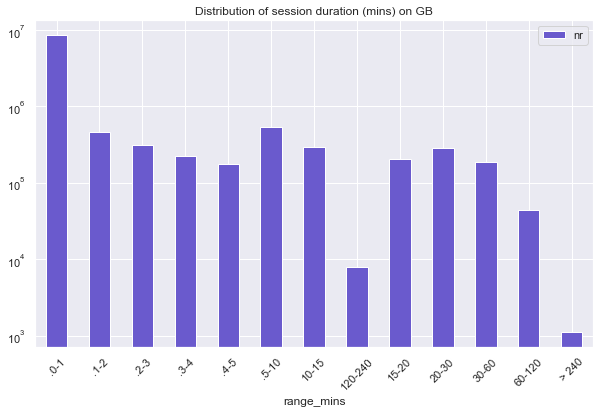

In [23]:
sns.set(rc = {'figure.figsize':(10,6)})
session_distribution_GB.plot(kind = 'bar', x = 'range_mins', y = 'nr', color = "slateblue", logy = True, rot = 45)
plt.title('Distribution of session duration (mins) on GB')
plt.show()

Session duration Pattern on global level ~ Session duration pattern on GB.

Also: 
- Default session: 30 minutes of inactivity (https://support.google.com/analytics/answer/2731565?hl=en)
- Session with more than 4 hours: 0.008%

-> outliers: remove for data preparation?

**Number of hits per session**

In [44]:
%%bigquery session_hit
WITH hits AS (
              SELECT 
                DISTINCT session_id ,
                TIMESTAMP_DIFF(session_end_time , session_start_time , minute) AS duration,
                COUNT(*) OVER(PARTITION BY session_id) nr_hits
              FROM `izettle-dp-pipeline-prod.legacy_views.google_analytics_session` 
),
hit_groups AS (
              SELECT
                session_id,
                CASE WHEN nr_hits < 5 THEN ".0-5"
                     WHEN nr_hits < 10 THEN ".5-10"
                     WHEN nr_hits < 20 THEN "10-20"
                     WHEN nr_hits < 50 THEN "20-50"
                     WHEN nr_hits < 100 THEN "50-100"
                     WHEN nr_hits < 200 THEN "100-200"
                     WHEN nr_hits < 300 THEN "200-300"
                     ELSE ">= 300" END AS hit_group
               FROM hits
)
SELECT 
  DISTINCT hit_group,
  COUNT(*) OVER(PARTITION BY hit_group)
FROM hit_groups
ORDER BY 2 DESC

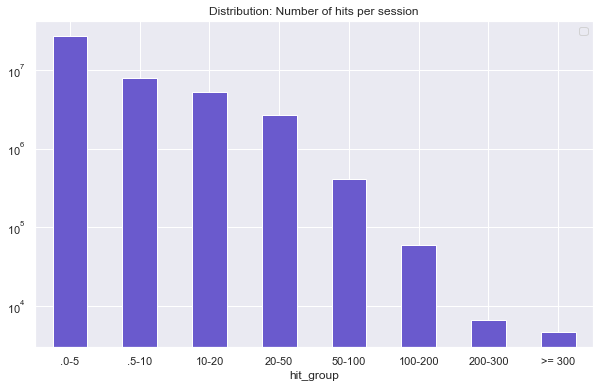

In [52]:
sns.set(rc = {'figure.figsize':(10,6)})
session_hit.plot(kind = 'bar', x = 'hit_group', y = 'f0_', color = 'slateblue', logy = True, rot = 0)
plt.title('Distribution: Number of hits per session')
plt.legend('')
plt.show()

**Number of client_id by organization_uuid**

In [51]:
%%bigquery converters_client
SELECT 
    organization_uuid,
    COUNT(client_id) AS nr_clientid
FROM legacy_views.google_analytics_session
GROUP BY organization_uuid
ORDER BY 1

In [54]:
converters_client = converters_client[converters_client.nr_clientid != 92944269]

*converters_client table is given back with one obs that is the total number of converters for all markets -> remove*

In [55]:
converters_client.nr_clientid.describe()

count    940845.000000
mean        193.679170
std         809.205545
min           0.000000
25%          25.000000
50%          59.000000
75%         146.000000
max      172059.000000
Name: nr_clientid, dtype: float64

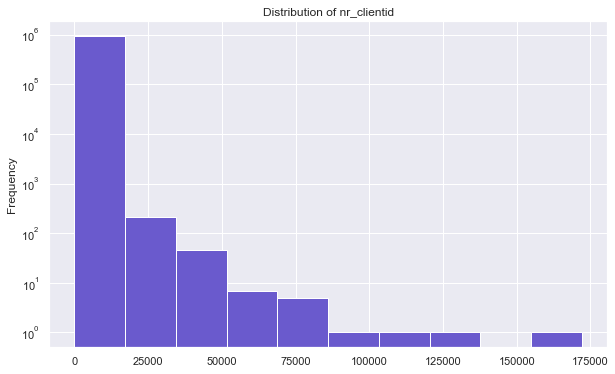

In [65]:
converters_client.nr_clientid.plot(kind = 'hist', logy = True, color = 'slateblue')
plt.title('Distribution of nr_clientid by organization_uuid')
plt.show()

*Check one merchant: one with max number of client_id*

In [58]:
converters_client[converters_client.nr_clientid == 172059]

,organization_uuid,nr_clientid
534271,914f9080-93af-11e7-abf3-ca17449df5e7,172059


In [59]:
%%bigquery client
SELECT 
    client_id, 
    organization_uuid,
    country_id,
    session_id,
    session_start_time,
    session_end_time,
    traffic_source_level_1,
    traffic_source_level_2,
    traffic_source_level_3,
    device_is_mobile,
    device_browser,
    is_portal_login_session
FROM legacy_views.google_analytics_session
WHERE organization_uuid = '914f9080-93af-11e7-abf3-ca17449df5e7'

In [60]:
client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182570 entries, 0 to 182569
Data columns (total 12 columns):
client_id                  172059 non-null object
organization_uuid          182570 non-null object
country_id                 182535 non-null object
session_id                 182570 non-null object
session_start_time         182570 non-null datetime64[ns, UTC]
session_end_time           182570 non-null datetime64[ns, UTC]
traffic_source_level_1     182570 non-null object
traffic_source_level_2     182570 non-null object
traffic_source_level_3     182570 non-null object
device_is_mobile           182570 non-null bool
device_browser             182570 non-null object
is_portal_login_session    182570 non-null bool
dtypes: bool(2), datetime64[ns, UTC](2), object(8)
memory usage: 14.3+ MB


In [63]:
print(client.session_start_time.max(), 'max start time')
print(client.session_start_time.min(), 'min start time')

2019-09-10 18:11:40+00:00 max start time
2017-09-07 09:08:41+00:00 min start time


In [64]:
client.session_id.nunique()

14992

**Number of converters by markets**

(approximate)

In [5]:
%%bigquery converters_market
WITH non AS(
            SELECT
                    country_id,
                    COUNT(DISTINCT client_id) AS nr_nonconverters
            FROM legacy_views.google_analytics_session 
            WHERE organization_uuid IS NULL
            GROUP BY country_id
),
con AS(
            SELECT
                    country_id,
                    COUNT(DISTINCT organization_uuid) AS nr_converters
            FROM legacy_views.google_analytics_session 
            GROUP BY country_id
)
SELECT
    con.country_id,
    nr_nonconverters,
    nr_converters
FROM con 
LEFT JOIN non
ON con.country_id = non.country_id

In [14]:
converters_market_melt = pd.melt(converters_market, id_vars = ['country_id'], var_name = 'type', value_name = 'nr')

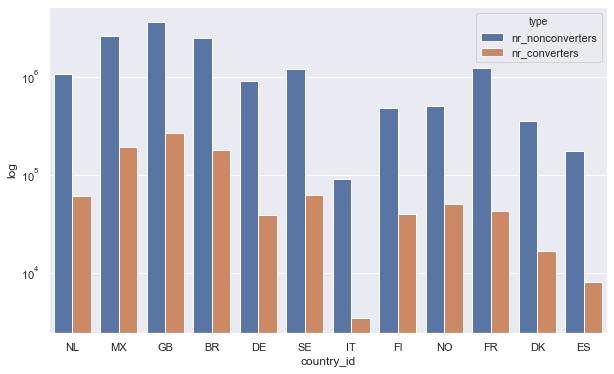

In [21]:
sns.set(rc = {'figure.figsize':(10,6)})
ax = sns.barplot(x = 'country_id', y = 'nr', hue = 'type', data = converters_market_melt)
ax.set_yscale('log')
plt.ylabel('log')
plt.show()

GB: has the highest number of both converters and non-converters and highest number of session.

**Traffic source: global level**

In [44]:
%%bigquery traffic_source_all
WITH traffic_session AS (
                        SELECT
                            DISTINCT session_id,
                            traffic_source_level_1,
                            traffic_source_level_2,
                            traffic_source_level_3
                        FROM `izettle-dp-pipeline-prod.legacy_views.google_analytics_session`
)
SELECT
    traffic_source_level_3,
    COUNT(*) AS nr_session
FROM traffic_session
GROUP BY traffic_source_level_3

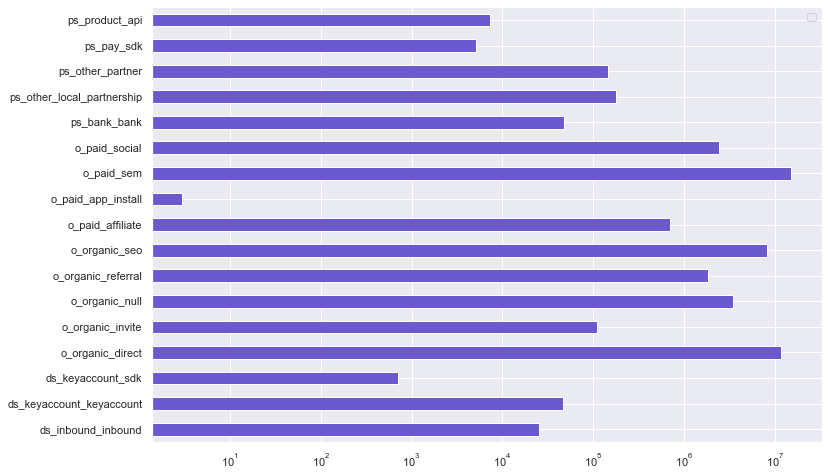

In [45]:
sns.set(rc = {'figure.figsize':(12,8)})
traffic_source_all.sort_values(by=['traffic_source_level_3']).plot.barh(x = 'traffic_source_level_3', y='nr_session', logx = True,
                         color = 'slateblue')
plt.legend('')
plt.ylabel('')
plt.show()

In [38]:
%%bigquery traffic_source_all_2
WITH traffic_session AS (
                        SELECT
                            DISTINCT session_id,
                            traffic_source_level_1,
                            traffic_source_level_2,
                            traffic_source_level_3
                        FROM `izettle-dp-pipeline-prod.legacy_views.google_analytics_session`
)
SELECT
    traffic_source_level_2,
    COUNT(*) AS nr_session
FROM traffic_session
GROUP BY traffic_source_level_2

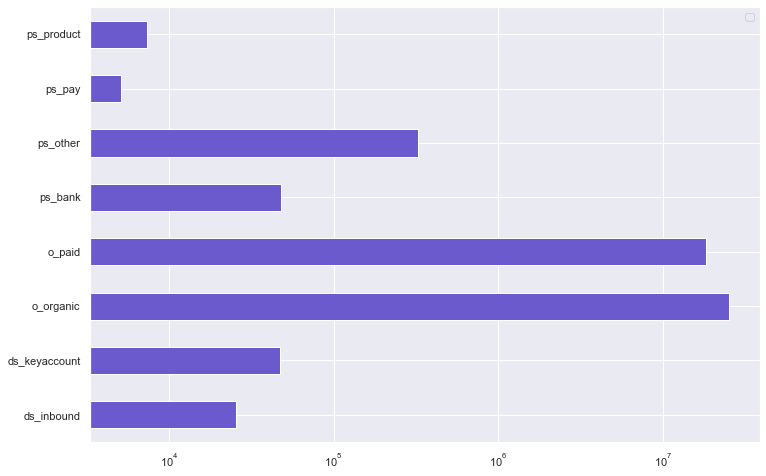

In [43]:
sns.set(rc = {'figure.figsize':(12,8)})
traffic_source_all_2.sort_values(by=['traffic_source_level_2']).plot.barh(x = 'traffic_source_level_2', y='nr_session', logx = True,
                         color = 'slateblue')
plt.legend('')
plt.ylabel('')
plt.show()

In [42]:
traffic_source_all_2.sort_values(by=['traffic_source_level_2'])

,traffic_source_level_2,nr_session
2,ds_inbound,25432
1,ds_keyaccount,47507
6,o_organic,25219066
0,o_paid,18149100
7,ps_bank,48134
4,ps_other,324445
5,ps_pay,5080
3,ps_product,7313


**Traffic source: market level**

In [46]:
%%bigquery traffic_source_market
WITH traffic_session AS (
                        SELECT
                            DISTINCT session_id,
                            country_id,
                            traffic_source_level_1,
                            traffic_source_level_2,
                            traffic_source_level_3
                        FROM `izettle-dp-pipeline-prod.legacy_views.google_analytics_session`
)
SELECT
    country_id,
    traffic_source_level_2,
    COUNT(*) AS nr_session
FROM traffic_session
GROUP BY country_id, traffic_source_level_2

In [4]:
country = list(traffic_source_market.country_id.unique())

In [6]:
del country[12]

In [7]:
country

['GB', 'DK', 'SE', 'ES', 'MX', 'IT', 'NL', 'FI', 'DE', 'FR', 'NO', 'BR']

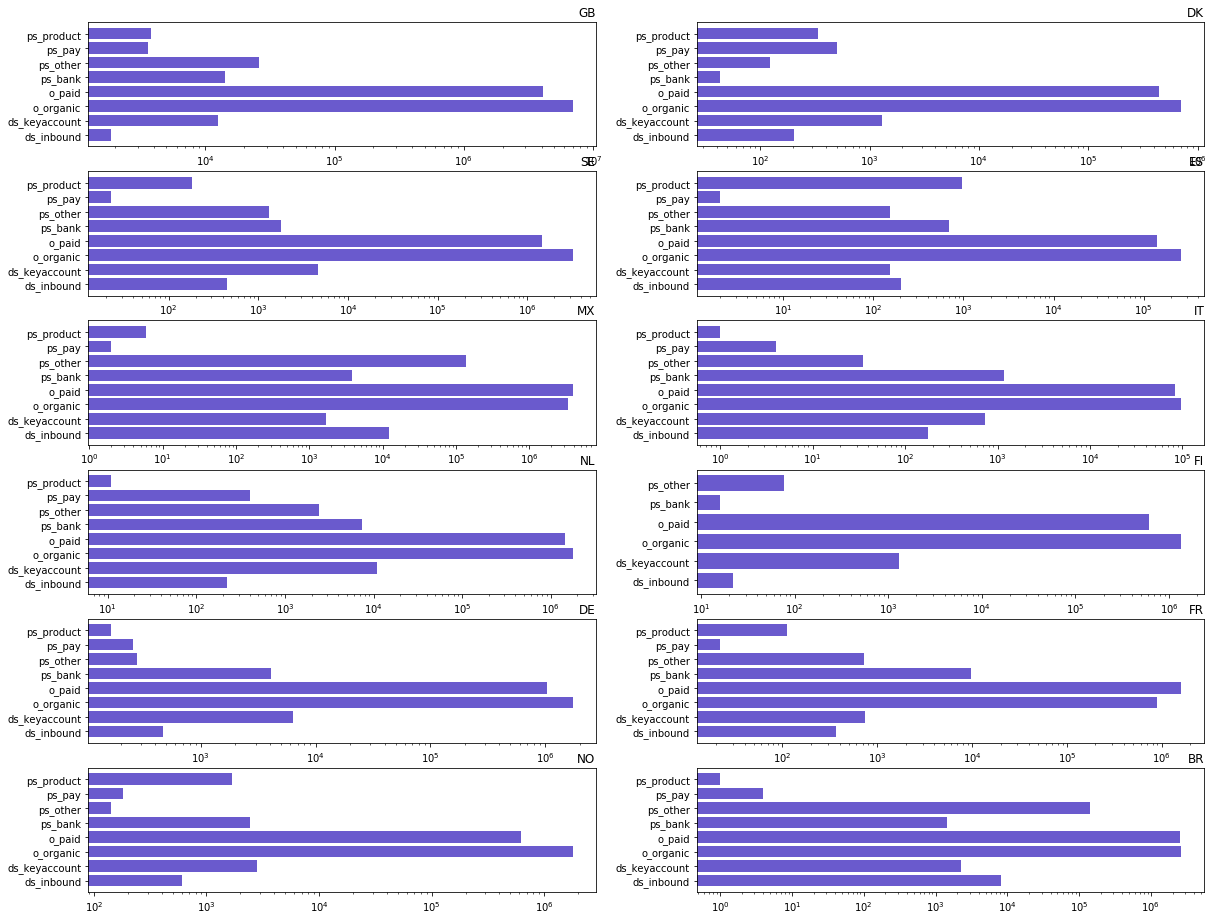

In [49]:
figure = plt.figure(figsize=(20,16))
for i in range(0, len(country)):
    text = country[i]
    df = traffic_source_market[traffic_source_market['country_id'] == country[i]]
    df_sorted = df.sort_values(by = ['traffic_source_level_2'])
    
    figure.add_subplot(6,2,i+1)
    plt.barh(y = 'traffic_source_level_2', width ='nr_session', data = df_sorted, log = True, color = 'slateblue')
    plt.title(text, loc = 'right')

plt.show()
    

### 2. User behaviour exploration

**Boarding time distribution**

journey from client _id to user_id

**Customer journey (touch points) distribution**